[![Open In Colab](https://img.shields.io/static/v1?message=Open%20in%20Colab&logo=googlecolab&label=%20&labelColor=5c5c5c&color=23c7a2&style=flat-square)](https://colab.research.google.com/github/einbandi/paradime/blob/master/notebooks/umap.ipynb)

Parametric UMAP
===============

In this example, we will set up a paraDime routine that is equivalent to a parametric implementation of UMAP. We will make use of the most important building blocks and methods of a [ParametricDR](../api/modules.rst#paradime.dr.ParametricDR) routine. The predefined [ParametricUMAP](../api/modules.rst#paradime.routines.ParametricUMAP) routine is defined in a similar way.

We start with some imports and define our dataset (MNIST handwritten image data):

In [1]:
from sklearn import manifold
import torch
import torchvision

from paradime import dr as pddr
from paradime import relations as pdrel
from paradime import transforms as pdtf
from paradime import loss as pdloss
from paradime import utils as pdutils

mnist = torchvision.datasets.MNIST(
    '../data',
    train=True,
    download=True,
)
mnist_data = mnist.data.reshape(-1, 28*28) / 255.
num_items = 5000

Relations
---------

Next, we define the global relations. UMAP uses the pairiwse distances between eavh data point and its `n`  nearest neighbors. The number of nearest neighbors `n` is a hyperparameter set by the user. The nearest neighbors are approximated using a tree-based algorithm. In paraDime, these approximate nearest neighbor relations are implemented as [NeighborBasedPDist](../api/modules.rst#paradime.relations.NeighborBasedPDist). UMAP then rescales the distances based on a Gaussian kernel, with kernel widths calculated for each data point by summed comparing kernel values to the binary logarithm of `n`. In paraDime, this transform is called [ConnectivityBasedRescale](../api/modules.rst#paradime.transforms.ConnectivityBasedRescale). Both the [NeighborBasedPDist](../api/modules.rst#paradime.relations.NeighborBasedPDist) relations and the [ConnectivityBasedRescale](../api/modules.rst#paradime.transforms.ConnectivityBasedRescale) transform take an `n_neighbors` parameter, but if the tranform is used inside the relations, the enclosing relations will automatically use the same values, so we only have to specify `n` once. In this example, we fix `n` to 30:

In [2]:
global_rel = pdrel.NeighborBasedPDist(
    transform=[
        pdtf.ConnectivityBasedRescale(n_neighbors=30),
        pdtf.Symmetrize(subtract_product=True),
    ]
)

Note that we also added a [Symmetrize](../api/modules.rst#paradime.transforms.Symmetrize) transform. The `subtract_product` option makes sure that the correct symmetrization for UMAP is used.

Now we sdefine the batch-wise relations. Here, it iso important to understand that UMAP uses negative-edge sampling. This means, that the batch sampler (which we will specify later in on of the training phases) basically returns a list of pairs of indices of data points, which can be used to calculate the distances along the *edges* between those data points. (In contrast, regular sampling just returns a batch of item indices and assumes that all pairwise distances will be calculated.)
At the moment, the only relations compatible with negative edge sampling in paraDime are [DistsFromTo](../api/modules.rst#paradime.relations.DistsFromTo), which we use here:

In [3]:
batch_rel = pdrel.DistsFromTo(
    transform=[
        pdtf.ModifiedCauchyTransform(
            min_dist=0.1,
            spread=1,
        )
    ]
)

You can see that we transform the distances with a [ModifiedCauchyTransform](../api/modules.rst#paradime.transforms.ModifiedCauchyTransform), which applies a slightly modified Cauchy distribution to the distances. The exact modification is controlled through the UMAP hyperparameters `min_dist` and `spread`.

Routine and Training Phases
---------------------------

Having defined both the global and the batch-wise relations, we can now set up the routine itself:

In [4]:
pumap = pddr.ParametricDR(
    dataset=mnist_data[:num_items],
    hidden_dims=[100,100,100],
    global_relations=global_rel,
    batch_relations=batch_rel,
    use_cuda=True,
    verbose=True,
)

2022-08-30 22:19:37,236: Registering dataset.


We use a subset of the MNIST dataset, and we want to use the GPU for training. We also set the `verbose` flag to see what's going on behind the scenes.

UMAP embeddings are initialized with a spectral embedding based on the computed relations between the data points. The usual way to perform an initialization step in paraDime is to set up an extra training phase in which the model is trained to embed the data in such a way that the embedding coordinates match a set of given positions. In t-SNE, these positions are simply the first two components of PCA. In UMAP, however, the positions used for initialization already require the computed relations. Therefore, we now have to compute the global relations:

In [5]:
pumap.compute_global_relations()

2022-08-30 22:19:37,427: Computing global relations 'rel'.
2022-08-30 22:19:37,428: Indexing nearest neighbors.
2022-08-30 22:19:52,769: Calculating probabilities.


Now we can use these relations to compute the spectral embedding. We simply use scikit-learn's [SpectralEmbedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html) with our relations as `'precomputed'` affinities:

In [6]:
affinities = pumap.global_relation_data['rel'].to_square_array().data

spectral = manifold.SpectralEmbedding(
    affinity='precomputed'
).fit_transform(affinities)

spectral = (spectral - spectral.mean(axis=0)) / spectral.std(axis=0)

pumap.add_to_dataset({
    'spectral': spectral
})

2022-08-30 22:19:56,085: Adding entry 'spectral' to dataset.


Because spectral embeddings can sometimes have slightly weird value ranges, we standardized the coordinate. We thenn added the standardized coordinates to our routine's dataset under the `'spectral'` key, making use of the [add_to_dataset](../api/modules.rst#paradime.dr.ParametricDR.add_to_dataset) method.

We can now define an initializationt training phase that makes use of these coordinates in a [PositionLoss](../api/modules.rst#paradime.loss.PositionLoss):

In [7]:
init_phase = pddr.TrainingPhase(
    name='spectral_init',
    epochs=10,
    batch_size=500,
    loss=pdloss.PositionLoss(position_key='spectral'),
    learning_rate=0.01,
    report_interval=2,
)

Apart from the phase's name and the report interval, all other parameters are hyperparameters that specify the training. Note that for this initialization phase, we use standard sampling.

The main phase of the training should learn the embedding based on the relations, using negative-edge sampling:

In [8]:
main_phase = pddr.TrainingPhase(
    name='main_embedding',
    epochs=60,
    batches_per_epoch=10,
    batch_size=500,
    sampling='negative_edge',
    neg_sampling_rate=3,
    loss=pdloss.RelationLoss(loss_function=pdloss.cross_entropy_loss),
    learning_rate=0.01,
    report_interval=5,
)

Due to the nature of the sampling, we have to define ourselves how many batches constitute an epoch (since samples are drawn with replacement, using edge relations as probabilities). UMAP uses a cross-entropy-like loss for comparing the global and batch-wise relations. This is implemented in paraDime as [cross_entropy_loss](../api/modules.rst#paradime.loss.cross_entropy_loss).

Training, Applying and Plotting
-------------------------------

Now all that's left to do is add those training phases to our routine. Note that the [add_training_phase](../api/modules.rst#paradime.dr.ParametricDR.add_training_phase) method does not only allows us to set a new phase's parameters individually, but also accepts a complete pre-defined [TrainingPhase](../api/modules.rst#paradime.dr.TrainingPhase) instance. After adding the phases, we can call the routine's [train](../api/modules.rst#paradime.dr.ParametricDR.train) method:

In [9]:
pumap.add_training_phase(init_phase)
pumap.add_training_phase(main_phase)
pumap.train()

2022-08-30 22:19:56,494: Beginning training phase 'spectral_init'.
2022-08-30 22:19:58,676: Loss after epoch 0: 15.795549988746643
2022-08-30 22:19:58,858: Loss after epoch 2: 4.691418915987015
2022-08-30 22:19:59,025: Loss after epoch 4: 1.1314118653535843
2022-08-30 22:19:59,192: Loss after epoch 6: 0.6685098484158516
2022-08-30 22:19:59,353: Loss after epoch 8: 0.4565475545823574
2022-08-30 22:19:59,433: Beginning training phase 'main_embedding'.
2022-08-30 22:20:00,637: Loss after epoch 0: 3.6028217673301697
2022-08-30 22:20:07,055: Loss after epoch 5: 2.651669219136238
2022-08-30 22:20:13,121: Loss after epoch 10: 2.5019873827695847
2022-08-30 22:20:19,244: Loss after epoch 15: 2.444426044821739
2022-08-30 22:20:25,439: Loss after epoch 20: 2.4334355145692825
2022-08-30 22:20:31,643: Loss after epoch 25: 2.3156993985176086
2022-08-30 22:20:37,891: Loss after epoch 30: 2.343563064932823
2022-08-30 22:20:43,959: Loss after epoch 35: 2.34099018573761
2022-08-30 22:20:49,959: Loss aft

Because we set the `verbose` flag, paraDime informs us about what's going on in the individual steps.

Once the training is complete, we can apply our routine to the training data:

<AxesSubplot:>

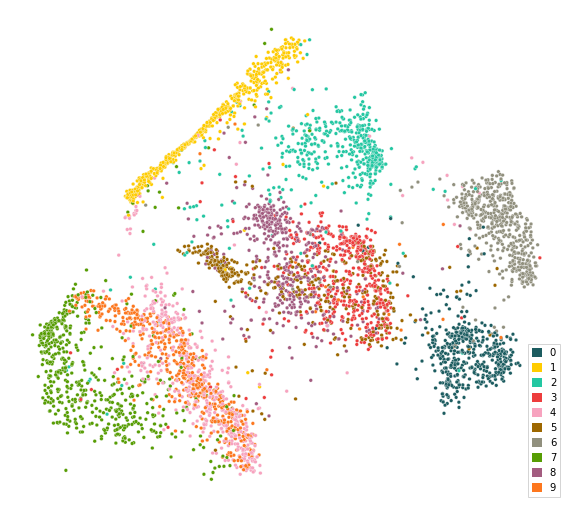

In [10]:
reduced = pumap.apply(mnist_data[:num_items])
pdutils.plotting.scatterplot(reduced, mnist.targets[:num_items])

Of course we can also apply our parametric UMAP to the whole MNIST data, without having to retrain it:

Once the training is complete, we can apply our parametric UMAP to the training data:

<AxesSubplot:>

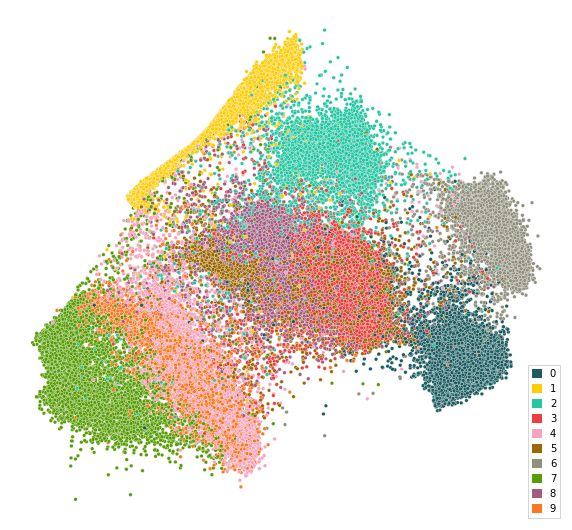

In [11]:
pdutils.plotting.scatterplot(pumap.apply(mnist_data), mnist.targets)

If you want to learn more about the individual steps, you can find more details in the section about the [Building Blocks of a paraDime Model](../building_blocks.rst) or in the [API Reference](../api/index.rst).